In [1]:
import os
from os import path
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [2]:
df = pd.read_csv(os.path.join("data","Demand for a doubleknit fabric p269 Montgomery Fore  TS.csv"),index_col=0)

df.head()

,x
1,656
2,659
3,601
4,624
5,545


In [3]:
df.head()

,x
1,656
2,659
3,601
4,624
5,545


In [4]:
df.describe()

,x
count,240.000000
mean,591.583333
std,49.393406
min,467.000000
25%,560.750000
50%,600.000000
75%,625.500000
max,704.000000


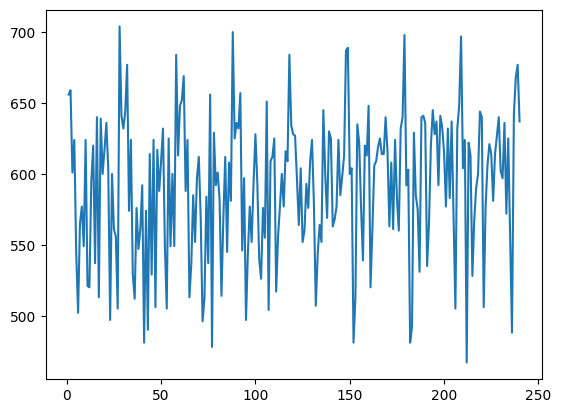

In [5]:
plt.plot(df)

In [6]:
def adfuller_get_p(ts):
    return adfuller(ts)[1]

def adfuller_print(ts,name = ""):
    alpha = 0.05

    dftest = adfuller(ts)

    dfoutput = pd.Series(dftest[0:4],index=["Test Statistic","p-value","Lags","Number of Observations"])

    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value

    print(f"Проверка на стационарность для ряда {name}")
    print(dfoutput)
    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha * 100}%. Ряд не стационарный.")

In [7]:
adfuller_print(df["x"],"Ткани")

Проверка на стационарность для ряда Ткани
Test Statistic             -4.922958
p-value                     0.000031
Lags                       12.000000
Number of Observations    227.000000
Critical Value (1%)        -3.459490
Critical Value (5%)        -2.874358
Critical Value (10%)       -2.573602
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


In [8]:
def delete_trend(ts):
    nottrend = []
    for i in range(1,len(ts)):
        nottrend.append(ts[i] - ts[i-1])
    return nottrend

In [9]:
def delete_seson(ts,s):
    notseson = []
    for i in range(s,len(ts)):
        notseson.append(ts[i] - ts[i-s])
    return notseson

In [10]:
nottrend = []
s = 12
notseson = []

ts = df["x"].to_numpy()

nottrend = delete_trend(ts)

notseson = delete_seson(ts,s)

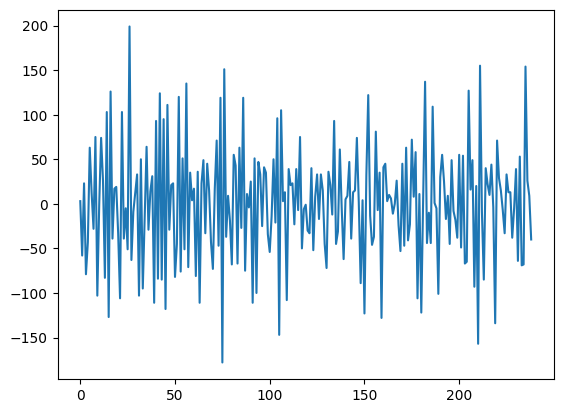

In [11]:
plt.plot(nottrend)

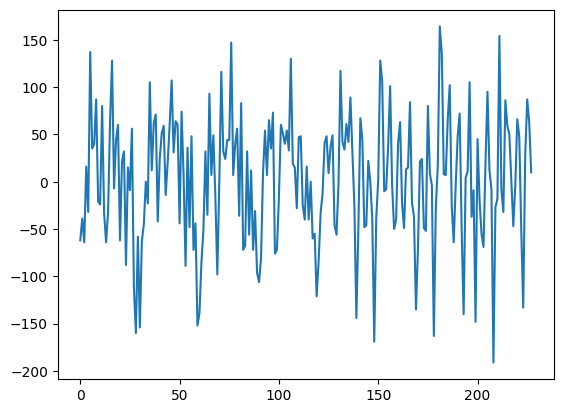

In [12]:
plt.plot(notseson)

In [13]:
adfuller_print(nottrend)

Проверка на стационарность для ряда 
Test Statistic           -6.287463e+00
p-value                   3.668145e-08
Lags                      1.200000e+01
Number of Observations    2.260000e+02
Critical Value (1%)      -3.459620e+00
Critical Value (5%)      -2.874415e+00
Critical Value (10%)     -2.573632e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


In [14]:
adfuller_print(notseson)

Проверка на стационарность для ряда 
Test Statistic           -6.936667e+00
p-value                   1.050359e-09
Lags                      1.100000e+01
Number of Observations    2.160000e+02
Critical Value (1%)      -3.460992e+00
Critical Value (5%)      -2.875016e+00
Critical Value (10%)     -2.573952e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


In [15]:
def autocor_print(ts,lags_autocor,lags_part_autocor):
    fig = plt.figure(figsize=(20,9))
    layout = (2,2)
    ts_ax = plt.subplot2grid(layout,(0,0), colspan=2)
    acf_ax = plt.subplot2grid(layout,(1,0))
    pacf_ax = plt.subplot2grid(layout,(1,1))

    ts.plot(ax=ts_ax)
    ts_ax.set_title("Time Series Analysis Plots")
    smt.graphics.plot_acf(ts,lags=lags_autocor,ax=acf_ax,alpha=0.5)
    smt.graphics.plot_pacf(ts,lags=lags_part_autocor,ax=pacf_ax,alpha=0.5)
    None

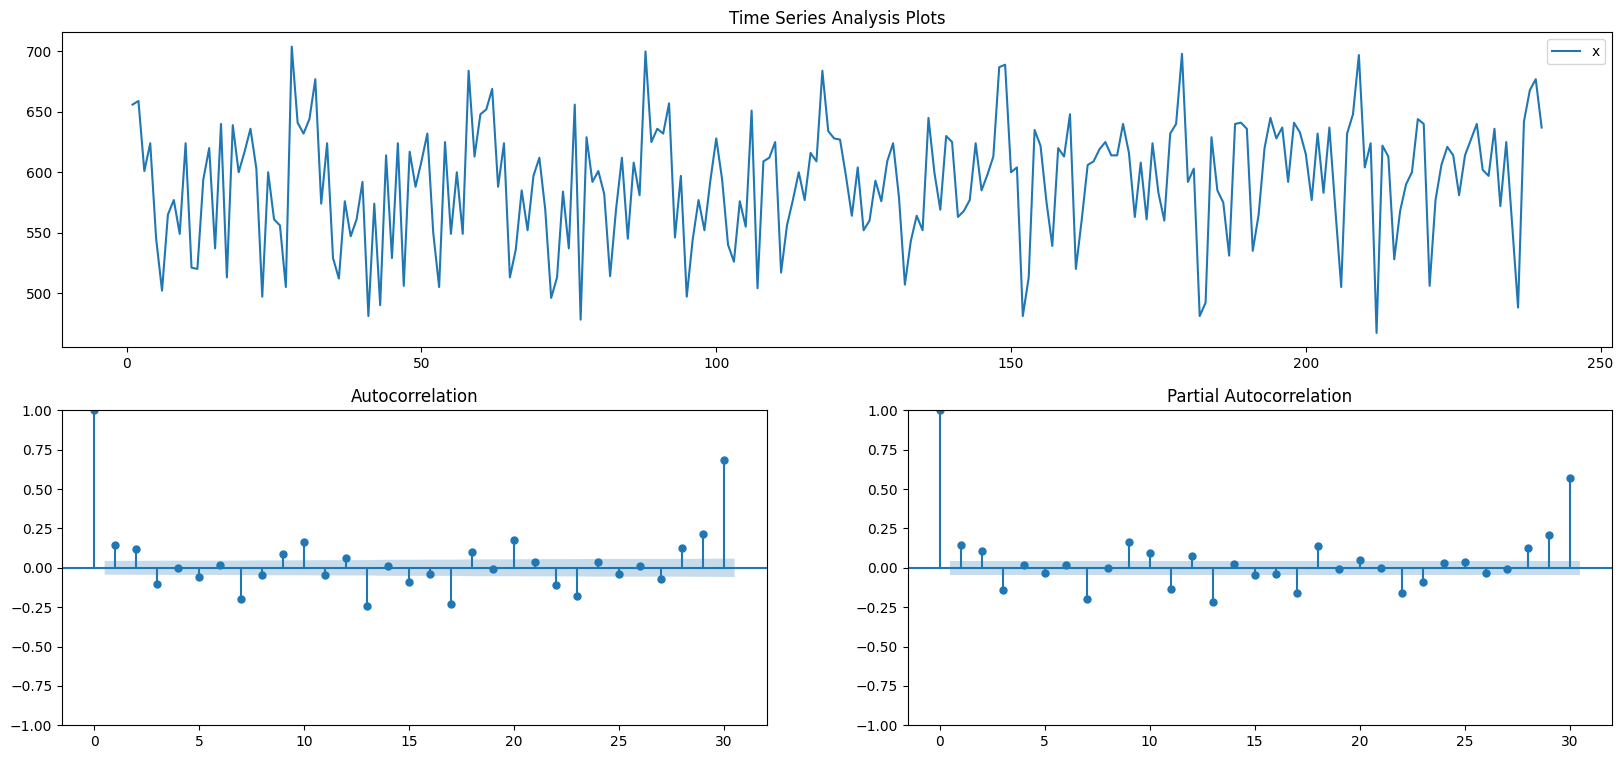

In [16]:
ts = pd.DataFrame(df["x"])

autocor_print(ts,30,30)

In [17]:
df.index = df.index - 1

df["t"] = df.index.values



ln = len(df)

train_cutoff = int(round(ln*0.75,0))
validate_cutoff = int(round(ln*0.9,0))

train_df = df[df["t"] <= train_cutoff]
validate_df = df[(df["t"] > train_cutoff) & (df["t"] <= validate_cutoff)]

forecast_df = df[df["t"] > validate_cutoff]

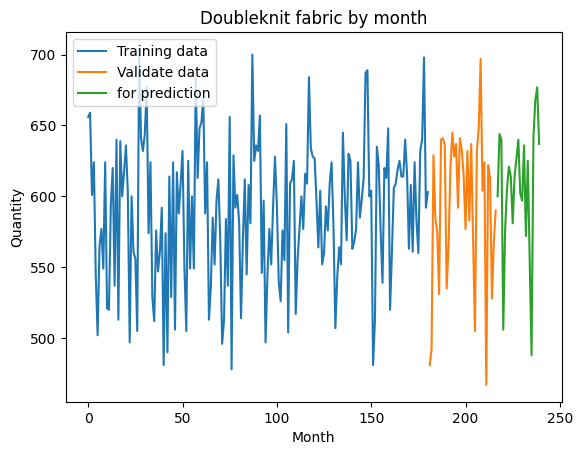

In [18]:
plt.plot(train_df.t,train_df.x,label="Training data")
plt.plot(validate_df.t,validate_df.x,label="Validate data")
plt.plot(forecast_df.t,forecast_df.x,label="for prediction")
plt.legend()
plt.title("Doubleknit fabric by month")
plt.ylabel("Quantity")
plt.xlabel("Month")
plt.show()

In [19]:
sel = ar_select_order(df.x,30,old_names=False)
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      x   No. Observations:                  240
Model:                    AutoReg(30)   Log Likelihood                -992.029
Method:               Conditional MLE   S.D. of innovations             27.249
Date:                Mon, 04 Mar 2024   AIC                           2048.058
Time:                        21:20:58   BIC                           2155.166
Sample:                            30   HQIC                          2091.358
                                  240                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        101.1695    150.647      0.672      0.502    -194.094     396.433
x.L1          -0.0196      0.048     -0.407      0.684      -0.114       0.075
x.L2           0.0862      0.047      1.826      0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


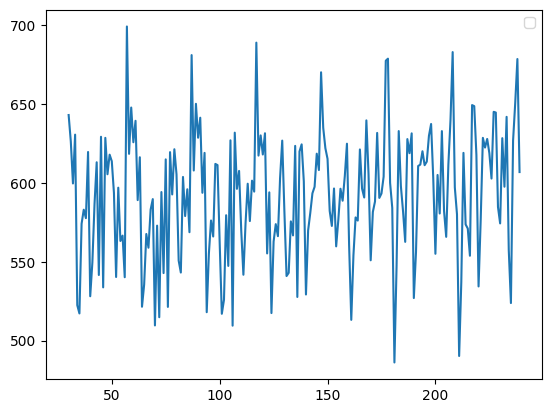

In [20]:
fig = res.plot_predict(0)

In [21]:
pred = res.predict(start=0,end=train_cutoff,dynamic=False)
v_pred = res.predict(start=train_cutoff+1,end=validate_cutoff,dynamic=False)
f_pred = res.predict(start=validate_cutoff+1,end=(forecast_df.t[len(df.t)-1]))

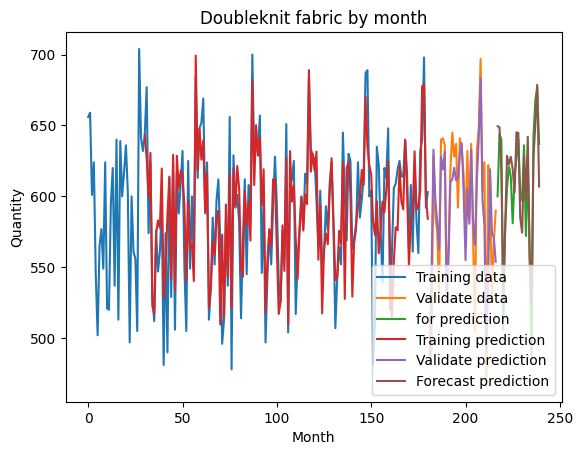

In [22]:
pred = res.predict(start=0,end=train_cutoff,dynamic=False)
v_pred = res.predict(start=train_cutoff+1,end=validate_cutoff,dynamic=False)
f_pred = res.predict(start=validate_cutoff+1,end=(forecast_df.t[len(df.t)-1]))
plt.plot(train_df.t,train_df.x,label="Training data")
plt.plot(validate_df.t,validate_df.x,label="Validate data")
plt.plot(forecast_df.t,forecast_df.x,label="for prediction")
plt.plot(train_df.t,pred,label="Training prediction")
plt.plot(validate_df.t,v_pred,label="Validate prediction")
plt.plot(forecast_df.t,f_pred,label="Forecast prediction")
plt.legend()
plt.title("Doubleknit fabric by month")
plt.ylabel("Quantity")
plt.xlabel("Month")
plt.show()

In [23]:
def SMAPE(y_true, y_pred):
    numerator = np.abs(y_true-y_pred)
    denumerator = (np.abs(y_true) + np.abs(y_pred))/2
    res = numerator/denumerator
    res = np.sum(res)
    res *= 100
    res /= len(y_true)
    return res

In [24]:
print("RMSE:", np.sqrt(mean_squared_error(forecast_df.x, f_pred)))
print("MAPE:", mean_absolute_percentage_error(forecast_df.x, f_pred))
print("MAE:", mean_absolute_error(forecast_df.x, f_pred))
print("R2: ", r2_score(forecast_df.x, f_pred))
print("SMAPE", SMAPE(forecast_df.x, f_pred))

RMSE: 21.78644228919351
MAPE: 0.029918561056589407
MAE: 17.65699532285329
R2:  0.763125929922331
SMAPE 2.9549882682969018
